In [1]:
from funcs import *
from tqdm import tqdm
import matplotlib

In [144]:
@jit(nopython=True)
def F(u):
    # l = 2.0
    # return u**l
    # return 1.0
    # return 0.0
    return np.square(u)+1.0

@jit(nopython=True)
def leftGU(x):
    return 0.0

@jit(nopython=True)
def rightGU(x):
    return 0.0

NU_ = Distrib(make_func("triangle_m_f", [-0.5,0.0,0.5]), supp_of_func=(-0.5,0.0,0.5))

def NU(x,xgrid):
    # return NU_(x)  
    # return 0.0
    mu = xgrid[int(len(xgrid)/2)]
    sigma = 0.05
    return np.exp(-0.5*np.square((x-mu)/sigma))*10.0
    # if x == xgrid[int(len(xgrid)/2)]:
    #     return 1.0

@jit(nopython =True)
def D(x, u):
    sigma = 0.05
    mu = 0.75
    # return u
    # return 1.0
    return 1.0 - np.exp(-0.5*np.square((x-mu)/sigma)) + 0.1*u

In [145]:
# @jit(nopython = True)
def solve(Nx,Nt,hx,tau,t,x,u_):
    u = np.copy(u_)
    Nx = len(x)
    B = np.zeros(shape=(Nx,))
    A = np.zeros(shape=(Nx, Nx))
    end_ = False
    for k in tqdm(range(Nt-1)):
        u_s = np.copy(u[k])        
        for s in range(20):
            A[0][0] = -1.0
            A[0][1] = 1.0
            A[Nx-1][Nx-1] = 1.0 
            A[Nx-1][Nx-2] = -1.0 
            for i in range(1,Nx-1):
                A[i][i-1] = 1.0/(4*hx**2)*D(x[i+1],u_s[i+1]) - 1.0/(4.0*hx**2)*D(x[i-1],u_s[i-1]) - 1.0/hx**2*D(x[i],u_s[i])
                A[i][i]   = 1.0/tau+2.0/(hx**2)*D(x[i],u_s[i])
                A[i][i+1] = -1.0/(4*hx**2)*D(x[i+1],u_s[i+1]) + 1.0/(4.0*hx**2)*D(x[i-1],u_s[i-1]) - 1.0/hx**2*D(x[i],u_s[i])
            B[0] = leftGU(x[0])
            B[Nx-1] = rightGU(x[Nx-1])
            for i in range(1,Nx-1):
                B[i] = F(u_s[i])+1.0/tau*u[k][i]
            try:
                u_s = np.matmul(np.linalg.inv(A),B)
            except:
                end_ = True
                break
        if end_:
            return u[:k+1]
        u[k+1] = np.copy(u_s)
    return u

In [146]:
hx = 0.01
ax= -1.0
bx = 1.0
Nx=  int((bx-ax)/hx)+1
xgrid = np.linspace(ax,bx,num=Nx)
tau = 0.01
T = 1.0
t0 = 0.0
Nt = int((t0+T-t0)/tau) + 1
tgrid = np.linspace(start=t0, stop=t0+T,num=Nt)
t = np.copy(tgrid)
x = np.copy(xgrid)
u = np.zeros(shape=(len(tgrid),len(xgrid)))

In [147]:
for i in range(len(x)):
    u[0][i] = NU(x[i],x)

In [148]:
u = solve(Nx,Nt,hx,tau,t,x,u)

 91%|█████████ | 91/100 [00:08<00:00, 11.29it/s]


In [149]:
last_iter = 0
for i in range(len(u)):
    if np.sum(np.isnan(u[i])) > 0 or np.sum(np.isinf(u[i])) > 0:
        last_iter = i-1
        break
    last_iter += 1
print(last_iter, len(t))

92 101


100%|██████████| 92/92 [00:00<00:00, 3407.50it/s]


Text(0.5, -0.1, '$k(x,u) = 1-e^{-0.5 (\\frac{x-\\mu}{\\sigma})^2}+0.1 \\cdot u$')

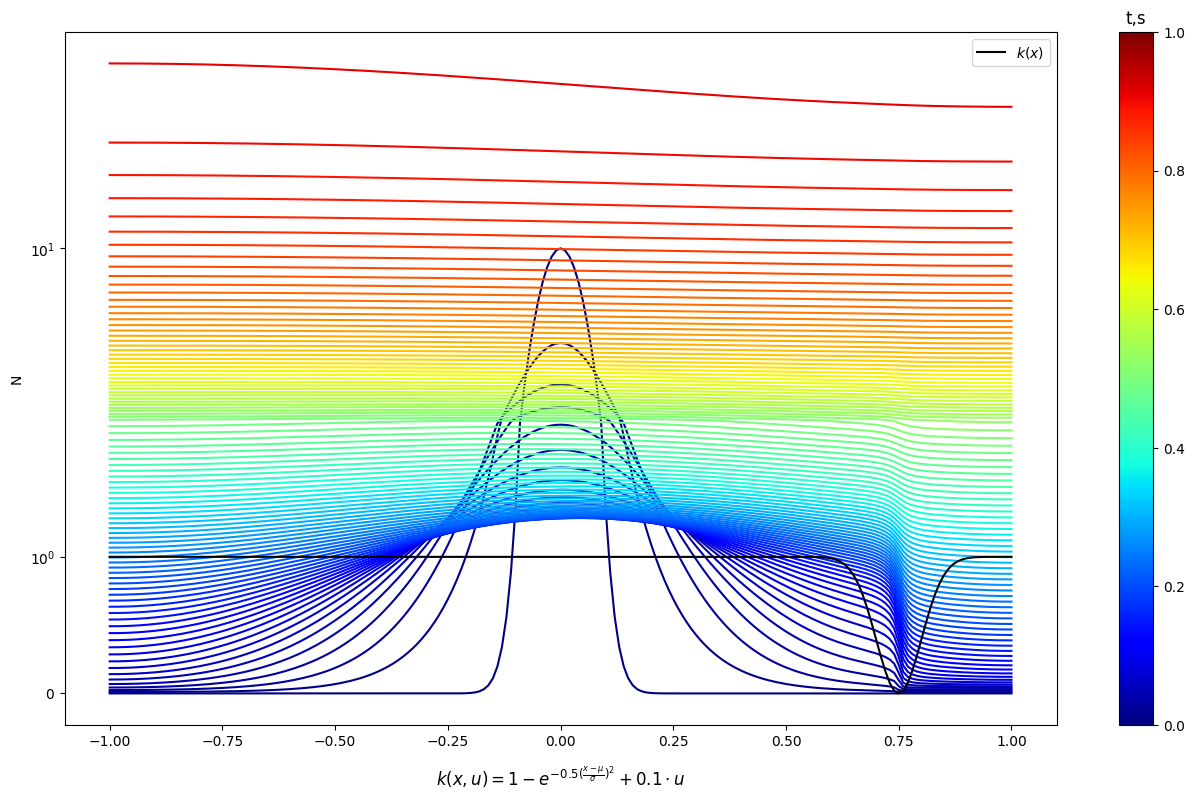

In [151]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
n_lines = last_iter
# n_lines = len(u)
# c = np.arange(1, n_lines+1)
c = np.copy(tgrid)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap= matplotlib.cm.jet
m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
for i in tqdm(range(n_lines)):
    ax.plot(xgrid, u[i],color= m.to_rgba(tgrid[i]))
ax.plot(xgrid, [D(x[i],0.0) for i in range(len(x))],c='k',label=r'$k(x)$')
ax.set_yscale('symlog')
clb = fig.colorbar(m, ax=ax)
clb.ax.set_title('t,s')
ax.set_ylabel('N')
ax.legend()
# ax.text(15, -0.01, "Correlation Graph between Citation & Favorite Count")
ax.set_title(r'$k(x,u) = 1-e^{-0.5 (\frac{x-\mu}{\sigma})^2}+0.1 \cdot u$', y=-0.1)